In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import yaml
import numpy as np
import random
import pytorch_lightning as pl
os.chdir('../')
print('cwd: ', os.getcwd())
from src.arch.model import VAE
from src.arch.lightning import trainerVAE

cwd:  /Users/gbemidebe/Documents/GitHub/knnGuidedDesign


In [3]:
# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
pl.seed_everything(seed)

Seed set to 42


42

In [4]:
run_id = 10 

In [5]:
vae_pretrained_weight_path = f'reports/VAE/hyper_search_checkpoints/{run_id}/best-chckpt.ckpt'
vae_pretrained = torch.load(vae_pretrained_weight_path)

In [6]:
vae_pretrained_params_path = f'reports/VAE/hyper_search_logs/knnMoleculeVAE/version_{run_id}/hparams.yaml'
vae_pretrained_params = yaml.safe_load(open(vae_pretrained_params_path))
vae_pretrained_params

{'batch_size': 8,
 'dec_hidden_dim_1': 64,
 'dec_hidden_dim_2': 64,
 'dropout': 0.0,
 'enc_hidden_dim_1': 64,
 'enc_hidden_dim_2': 64,
 'height_dim': 41,
 'input_dim': 2378,
 'latent_dim': 32,
 'learning_rate': 0.001,
 'max_len': 58,
 'num_epochs': 150,
 'seed': 2050,
 'split_ratio': 0.3,
 'width_dim': 58}

In [7]:
vae = trainerVAE(
        input_dim=int(vae_pretrained_params['input_dim']), 
        latent_dim=int(vae_pretrained_params['latent_dim']),
        enc_hidden_dim_1 = int(vae_pretrained_params['enc_hidden_dim_1']), 
        enc_hidden_dim_2 = int(vae_pretrained_params['enc_hidden_dim_2']), 
        dec_hidden_dim_1=int(vae_pretrained_params['dec_hidden_dim_1']),
        dec_hidden_dim_2=int(vae_pretrained_params['dec_hidden_dim_2']), 
        dropout=float(vae_pretrained_params['dropout'])
        )

In [8]:
vae.encoder[0].weight

Parameter containing:
tensor([[ 0.0157,  0.0170, -0.0048,  ...,  0.0003, -0.0186,  0.0038],
        [-0.0085, -0.0053, -0.0106,  ...,  0.0044,  0.0197, -0.0159],
        [-0.0089,  0.0175, -0.0047,  ...,  0.0143, -0.0198, -0.0167],
        ...,
        [ 0.0057, -0.0073,  0.0205,  ..., -0.0036, -0.0172, -0.0035],
        [ 0.0099, -0.0159,  0.0059,  ...,  0.0192, -0.0164, -0.0006],
        [-0.0138,  0.0126, -0.0129,  ..., -0.0062, -0.0060,  0.0034]],
       requires_grad=True)

In [9]:
vae.load_state_dict(vae_pretrained['state_dict'])

<All keys matched successfully>

In [10]:
vae.encoder[0].weight

Parameter containing:
tensor([[-0.0110,  0.0062, -0.0040,  ...,  0.0037,  0.0146, -0.0024],
        [-0.0088, -0.0040, -0.0008,  ...,  0.0185,  0.0129, -0.0040],
        [ 0.0195,  0.0034, -0.0202,  ...,  0.0005,  0.0068,  0.0001],
        ...,
        [-0.0011, -0.0048,  0.0100,  ..., -0.0172,  0.0047, -0.0004],
        [-0.0009, -0.0050,  0.0100,  ...,  0.0182,  0.0046, -0.0036],
        [ 0.0118,  0.0109, -0.0017,  ...,  0.0150,  0.0069, -0.0192]],
       requires_grad=True)

In [11]:
vae_pretrained['state_dict']['encoder.0.weight']

/Users/gbemidebe/miniconda3/envs/MatML/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[-0.0110,  0.0062, -0.0040,  ...,  0.0037,  0.0146, -0.0024],
        [-0.0088, -0.0040, -0.0008,  ...,  0.0185,  0.0129, -0.0040],
        [ 0.0195,  0.0034, -0.0202,  ...,  0.0005,  0.0068,  0.0001],
        ...,
        [-0.0011, -0.0048,  0.0100,  ..., -0.0172,  0.0047, -0.0004],
        [-0.0009, -0.0050,  0.0100,  ...,  0.0182,  0.0046, -0.0036],
        [ 0.0118,  0.0109, -0.0017,  ...,  0.0150,  0.0069, -0.0192]],
       device='mps:0')

# Generate new molecules

In [12]:
int(vae_pretrained_params['input_dim']), int(vae_pretrained_params['latent_dim'])

(2378, 32)

In [13]:
vae.eval()
with torch.no_grad():
    samples = torch.randn(10, int(vae_pretrained_params['latent_dim']))
    decoded_samples = vae.decoder(samples)

print(decoded_samples.shape)

torch.Size([10, 2378])


In [14]:
vae.eval()
with torch.no_grad():
    encoded_samples = vae.encoder(decoded_samples)

print(encoded_samples.shape)

torch.Size([10, 64])


In [15]:
from src.data.loader import load_vae_data
_, _, _, selfies_alphabet, \
                    largest_selfies_len, vocab_stoi, vocab_itos = load_vae_data(seed=1004, test_size=0.2, csv_path='./data/pretrain_data.csv')

--> Translating SMILES to SELFIES...0%
--> Finished translating SMILES to SELFIES...100%
--> Creating one-hot encoding...0%
--> Finished creating one-hot encoding...100%


In [16]:
from src.data.utils import valid_smiles # generated_molecules_to_smiles
import selfies as sf
import numpy as np

def generated_molecules_to_smiles(generated_molecules, width, height, vocab_itos):
    # Reshape satisfying_molecules_tensor back to a 3D tensor
    generated_molecules_tensor_3d = generated_molecules.view(-1, width, height)
    # Convert the PyTorch 3D tensor to a NumPy array
    generated_molecules_numpy = generated_molecules_tensor_3d.numpy()

    max_values = np.max(generated_molecules_numpy, axis=2, keepdims=True)
    generated_data = np.where(generated_molecules_numpy == max_values, 1, 0)

    ### Reproduce SMILES list and visualize the output images
    output_smiles_list = []
    for i in range (0,len(generated_data)):
        sm = sf.decoder(sf.encoding_to_selfies(generated_data[i].tolist(), vocab_itos, enc_type="one_hot"))
        output_smiles_list.append(sm)

    return output_smiles_list

In [17]:
# decoded to smiles
decoded_samples_smiles = generated_molecules_to_smiles(
                        generated_molecules = decoded_samples, 
                        width = int(vae_pretrained_params['width_dim']), 
                        height = int(vae_pretrained_params['height_dim']),
                        vocab_itos = vocab_itos)
decoded_samples_smiles_valid = valid_smiles(decoded_samples_smiles)

--> Percentage of valid SMILES strings: 100.00%


In [18]:
decoded_samples_smiles_valid

['NNNNNNNNNNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NN=[N+1]NNNNNNNNNNNNNNNNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NNNNNNNNNNNNNNNNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NNNNNNN[NH1][NH1]

In [19]:
decoded_samples_smiles

['NNNNNNNNNNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NN=[N+1]NNNNNNNNNNNNNNNNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NNNNNNNNNNNNNNNNN[NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1][NH1]',
 'NNNNNNN[NH1][NH1]

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

def show_both_chemical_space(
                        redox_potential: list, 
                             vae_pretain_data: list, 
                             figsize = (14, 6)):
    """
    Plot a t-SNE plot of the molecular fingerprints for a list of SMILES strings
    params:
            redox_potential: a list of SMILES strings
            vae_pretain_data: a list of SMILES strings
    returns:
    fig: matplotlib figure of scatter plot and make sure they are legende based on input parameters
    """
    fig, ax = plt.subplots(1, 3, facecolor='w', figsize=figsize)
    # Generate molecular fingerprints using Morgan algorithm with radius=2
    smiles = redox_potential + vae_pretain_data # merge into 1 list
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm), 2) for sm in smiles]
    # Convert the list of fingerprints to a numpy array
    fps = np.asarray([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm), 2) for sm in smiles])
    tsne_ = TSNE(n_components=2)
    pca_ = PCA(n_components=2)
    umap_ = umap.UMAP(n_neighbors = 25, n_components = 2, low_memory = False, min_dist = 0.001)
    tsne_result = tsne_.fit_transform(fps)
    pca_result = pca_.fit_transform(fps)
    umap_result = umap_.fit_transform(fps)
    
    # index redox_potential and then vae_pretrain_data
    redox_potential_pos = range(len(redox_potential))
    vae_pretain_pos = range(len(redox_potential), len(redox_potential)+len(vae_pretain_data))
    
    ax[0].scatter(pca_result[redox_potential_pos][:, 0], pca_result[redox_potential_pos][:, 1], label='FT')
    ax[0].scatter(tsne_result[vae_pretain_pos][:,0], tsne_result[vae_pretain_pos][:,1], label = 'PT')
    ax[0].set_xlabel(r'$\rm PCA \ 1$', fontsize = 20)
    ax[0].set_ylabel(r'$\rm PCA \ 2$', fontsize = 20)
    ax[0].tick_params(axis='x', labelsize=18)
    ax[0].tick_params(axis='y', labelsize=18)
    ax[0].grid(False)
    
    ax[1].scatter(tsne_result[redox_potential_pos][:,0], tsne_result[redox_potential_pos][:,1], label='FT')
    ax[1].scatter(tsne_result[vae_pretain_pos][:,0], tsne_result[vae_pretain_pos][:,1], label='PT')
    ax[1].set_xlabel(r'$\rm tSNE \ 1$', fontsize=20)
    ax[1].set_ylabel(r'$\rm tSNE \ 2$', fontsize=20)
    ax[1].tick_params(axis='x', labelsize=18)
    ax[1].tick_params(axis='y', labelsize=18)
    ax[1].grid(False)
    ax[1].legend(loc='best', frameon=True, shadow=True)
    
    ax[2].scatter(umap_result[redox_potential_pos][:,0], umap_result[redox_potential_pos][:,1], label='FT')
    ax[2].scatter(umap_result[vae_pretain_pos][:, 0], umap_result[vae_pretain_pos][:,1], label='PT')
    ax[2].set_xlabel(r'$\rm UMAP \ 1$', fontsize=20)
    ax[2].set_ylabel(r'$\rm UMAP \ 2$', fontsize=20)
    ax[2].tick_params(axis='x', labelsize=18)
    ax[2].tick_params(axis='y', labelsize=18)
    ax[2].grid(False)
    
    plt.tight_layout()
    plt.show()

In [21]:
pretrained_data = pd.read_csv('./data/pretrain_data.csv')
pretrained_data.head()

,smiles
0,CC(C)[S](C)(=O)=O
1,COC(C)(C)C
2,C=CCO
3,C1CS1
4,c1c[nH]nn1


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


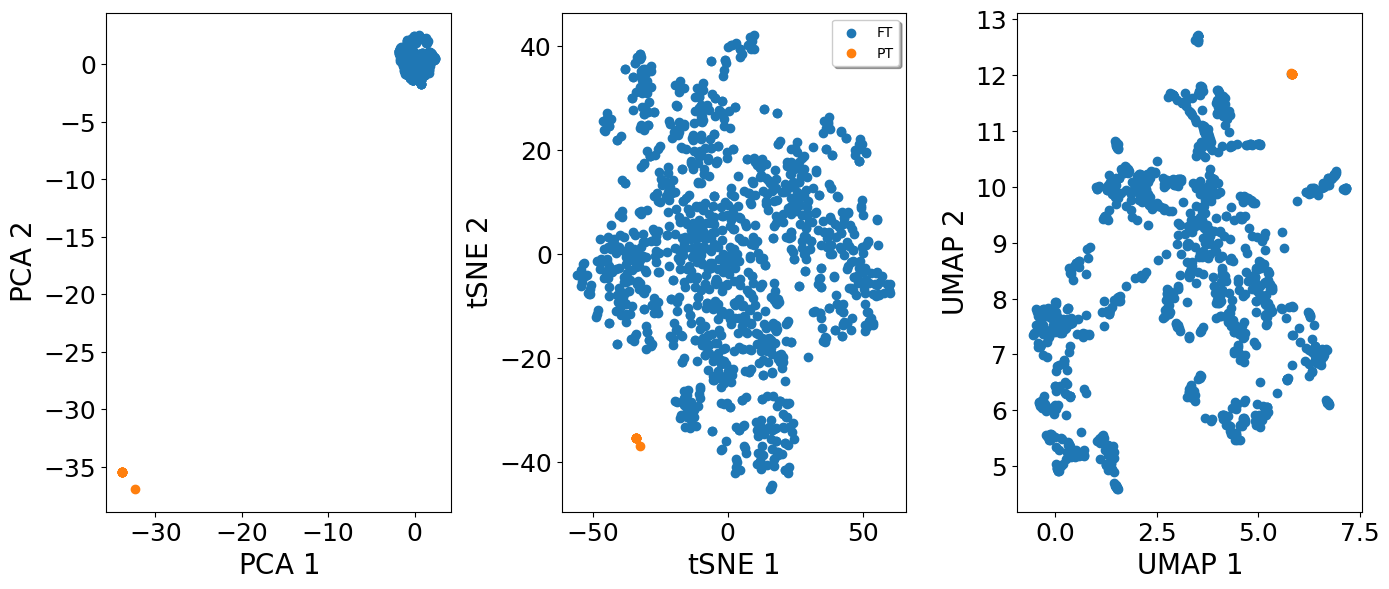

In [22]:
show_both_chemical_space(
                        redox_potential = pretrained_data['smiles'].tolist(), 
                        vae_pretain_data = decoded_samples_smiles)